Code created by Margot Wagner (2/26/2020)

In [10]:
# import packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.interpolate import interp1d

First, we will look at the Markov model for the voltage gated calcium channels

<img src="./figs/vdcc_kinetics.png" width="400">

## Voltage Waveform
First, we want to look at the action potential voltage waveform being used to drive the state transitions of the VDCCs. This waveform data was generated using NEURON.

In [11]:
filename = '~/projects/mcell/simple_geom/input_waveform_data/pre_ap_voltage.txt'
v_m_df = pd.read_csv(filename, delim_whitespace=True, header=None)
v_m = v_m_df.to_numpy()

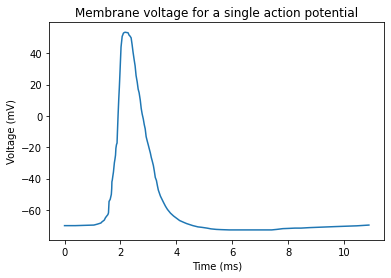

In [12]:
plt.plot(v_m[:,0]*1000,v_m[:,1])
plt.title('Membrane voltage for a single action potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.show()

## Interpolation

We want a finer grained voltage waveform, so we can use look at interpolation schemes in order to get a voltage waveform sampled at every microsecond (1/1000 ms). Given the shape of our waveform, we will use cubic interpolation.  
_Note:_ it is a function not array values.

In [13]:
vm_cubic_interp = interp1d(v_m[:,0]*1000, v_m[:,1], kind = 'cubic',fill_value="extrapolate")
trange = np.arange(0, 11, 1e-3)
v_m = vm_cubic_interp

## Transitions

Next, we want to look at the actual transitions (alpha, beta, and k) seen in the above figure. We can take the data that was already calculated to look at the shape of these transitions with time due to the action potential.

Alternatively, we can explicitly solve the equations to get the exact time points we want for our Markov model. The equations are those from the Nadkarni et al. 2010 paper original found in Bischofberger and Jonas 2002. This is good because we can use our fine-grained voltage waveform. We already have our voltage function (v_m), so we just have to define functions for our transition probabilities. These will be dependent on time through voltage.

### Functions

In [14]:
# Temperature adjustment from paper
q10 = 2.0  # rxn rate increase with 10 degC temp change; assumuption of uniform q10 for all reactions here
delta_temp = 10.0  # parameters are given at 24C so raise temp by 10C to 34C (rat internal temp)
temp_comp = q10 ** (delta_temp / 10.)  # change in rxn rate due to deltaT eqtn

In [15]:
# All in units of ms

# 1st transition
v1 = 49.14          # mV
def alpha_1(t):
    '''
    alpha 1 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_1
    '''
    
    a1o = 4.04          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a1o * np.exp(v_m(t)/v1)

def beta_1(t):
    '''
    beta 1 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_1
    '''
    
    b1o = 2.88          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b1o * np.exp(-v_m(t)/v1) 

# 2nd transition
v2 = 42.08          # mV
def alpha_2(t):
    '''
    alpha 2 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_2
    '''
       
    a2o = 6.70          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a2o * np.exp(v_m(t)/v2)

def beta_2(t):
    '''
    beta 2 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_2
    '''
    
    b2o = 6.30          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b2o * np.exp(-v_m(t)/v2) 

# 3rd transition
v3 = 55.31          # mV
def alpha_3(t):
    '''
    alpha 3 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_3
    '''
    
    a3o = 4.39          # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a3o * np.exp(v_m(t)/v3)

def beta_3(t):
    '''
    beta 3 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_3
    '''
    
    b3o = 8.16          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b3o * np.exp(-v_m(t)/v3) 

# 4th transition
v4 = 26.55          # mV
def alpha_4(t):
    '''
    alpha 4 forward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for alpha_4
    '''
    
    a4o = 17.33         # msec-1
    #adjust = 0.5        # changes by Tom and Suhita
    adjust = 1
    
    return adjust * temp_comp * a4o * np.exp(v_m(t)/v4)

def beta_4(t):
    '''
    beta 4 backward transition rate
    parameters:     time (t)      int/double value or array
    returns:        equation for beta_4
    '''
    
    b4o = 1.84          # msec-1
    #adjust = 0.5
    adjust = 1
    
    return adjust * temp_comp * b4o * np.exp(-v_m(t)/v4) 

As well as the transition rates, we can also look at the calcium leak rate constant (k_Ca) which is also voltage dependent. Also from Biscofberger, but more explanation in Bartol 2015.

In [16]:
# 1/ms
def k_ca(t):
    f_ca = 511080.19/1802251 # correction factor for only calcium in current
    g_hva = f_ca * 1.55 * 2.4e-12       # conductance (3.72 pS)
    c = 80.36                    # mV
    d = 0.3933                   # parameter determining current rectification and reversal potential
    e_c = 1.6e-19                # Coulombie charge of one electron (e = F/NA)
    Z_ca = 2                     # Charge of calcium ion
    #adjust = 0.183               # changes by Tom and Suhita
    adjust = 1
    
    return adjust * g_hva * v_m(t) * (d - np.exp(-v_m(t)/c)) / ((1000**2)*Z_ca*e_c*(1 - np.exp(v_m(t)/c)))
    

### Graphs

Text(0, 0.5, 'Transition rate (1/ms)')

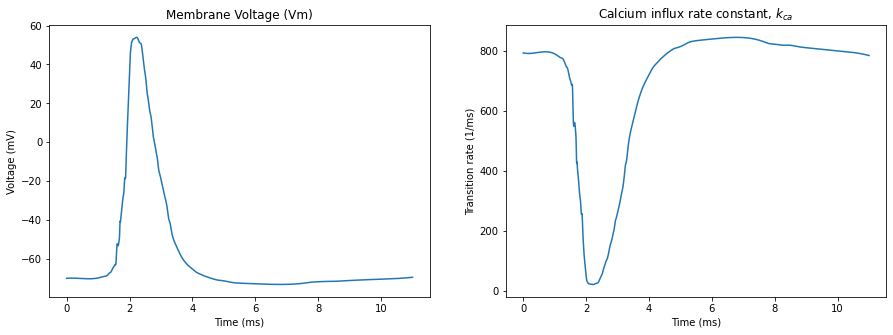

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].plot(trange,v_m(trange))
ax[0].set_title('Membrane Voltage (Vm)')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Voltage (mV)')

ax[1].plot(trange,k_ca(trange))
ax[1].set_title('Calcium influx rate constant, $k_{ca}$')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Transition rate (1/ms)')

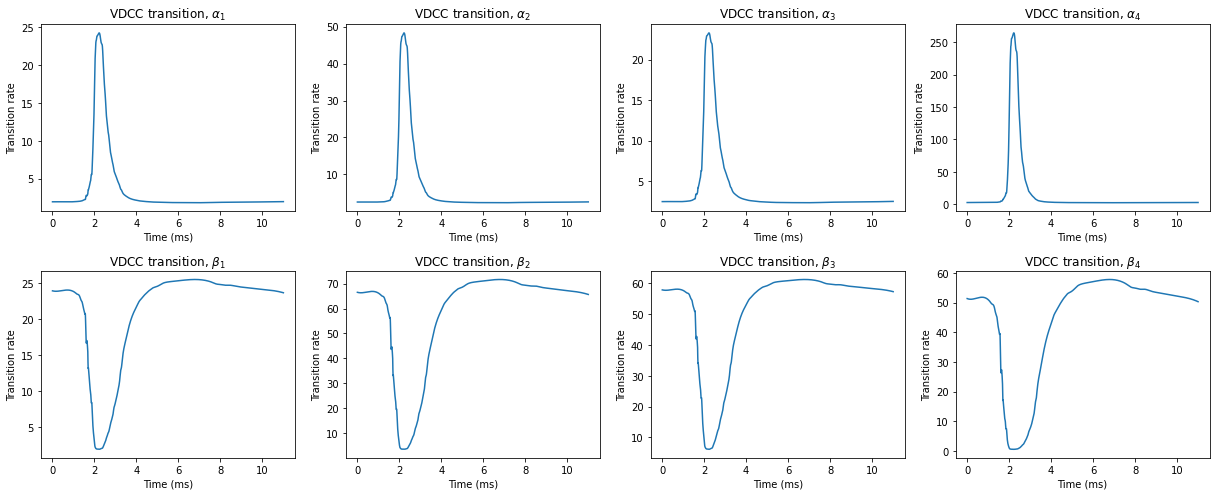

In [9]:
fig, ax = plt.subplots(2, 4, figsize = (17,7))

for i in range(2):
    for j in range(4):
        ax[i][j].set_xlabel('Time (ms)')
        ax[i][j].set_ylabel('Transition rate')
        if i==0:
            ax[i][j].set_title(r'VDCC transition, $\alpha_{%s}$' %(j+1))
            if j==0:
                ax[i][j].plot(trange,alpha_1(trange))
            elif j==1:
                ax[i][j].plot(trange,alpha_2(trange))
            elif j==2:
                ax[i][j].plot(trange,alpha_3(trange))
            elif j==3:
                ax[i][j].plot(trange,alpha_4(trange))
        else:
            ax[i][j].set_title(r'VDCC transition, $\beta_{%s}$' %(j+1))
            if j==0:
                ax[i][j].plot(trange, beta_1(trange))
            elif j==1:
                ax[i][j].plot(trange,beta_2(trange))
            elif j==2:
                ax[i][j].plot(trange,beta_3(trange))
            elif j==3:
                ax[i][j].plot(trange,beta_4(trange))
        

fig.tight_layout()
plt.show()

# Solving n(t) numerically (rate equations)


Before we simulate this process stochastically, we can solve for the number of channels in each state numerically using an ode solver. This is equivalent to a mean solution for an infinite number of channels. Each state can be described as follows:

<img src="vdcc_kinetics.png" width="400">

$$ 
\frac{dC0}{dt} 
= \beta_1(V)C1 - \alpha_1(V)C0 
$$
$$ 
\frac{dC1}{dt} 
= \alpha_1(V)C0 + \beta_2(V)C2 - (\beta_1(V) + \alpha_2(V))C1 
$$
$$ 
\frac{dC2}{dt} 
= \alpha_2(V)C1 + \beta_3(V)C3 - (\beta_2(V) + \alpha_3(V))C2
$$
$$ 
\frac{dC3}{dt} 
= \alpha_3(V)C2 + \beta_4(V)O - (\beta_3(V) + \alpha_4(V))C3
$$
$$ 
\frac{dO}{dt} 
= \alpha_4(V)C3 - \beta_4(V)O
$$
$$ 
\frac{dCa}{dt} 
= k_{Ca}(V)O
$$

We want to define these similarly as Python functions.

These equations constitute the master equations as the mean for the Fokker-Planck equations...need coupled set of equations for std dev/var.

In [17]:
def vdcc_odes(t, state):
    # ODEs to describe vdcc states according to Markov diagram
    # params        t (time)
    #               state (states of vdcc)
    # return        odes describing each state
    c0, c1, c2, c3, o, ca = state
    
    eqtns = []
    eqtns.append(beta_1(t)*c1 - alpha_1(t)*c0)
    eqtns.append(alpha_1(t)*c0 + beta_2(t)*c2 - (beta_1(t)+alpha_2(t))*c1)
    eqtns.append(alpha_2(t)*c1 + beta_3(t)*c3 - (beta_2(t)+alpha_3(t))*c2)
    eqtns.append(alpha_3(t)*c2 + beta_4(t)*o - (beta_3(t)+alpha_4(t))*c3)
    eqtns.append(alpha_4(t)*c3 - beta_4(t)*o)
    eqtns.append(k_ca(t)*o)
    
    return eqtns
    
    

In [18]:
from scipy.integrate import solve_ivp
# solve_ivp(fun, t_span, y0)
# returns bunch object with:
# t     (n_points), time points
# y     (n, n_points), values of the solution at t
sol = solve_ivp(vdcc_odes,[0, 11], [1, 0, 0, 0, 0, 0])

In [19]:
# benchmark
dt = 1e-3
t_start = 0
t_stop = 10
#n_vdcc = 65
trange = np.arange(t_start, t_stop+dt, dt)
print(len(trange))
%timeit -n 1 -r 10 solve_ivp(vdcc_odes,[t_start, t_stop+dt], [1, 0, 0, 0, 0, 0], t_eval=trange)
#solve_ivp(vdcc_odes,[t_start, t_stop+dt], [1, 0, 0, 0, 0, 0], t_eval=trange)

10001
882 ms ± 33.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Plotting ODE solutions

The ODE solutions are effectively the mean result as the number of trials and/or number of channels goes to infinity. We can use the ODE solution to also figure out there variance using the probability a channel will be in a given state at time, t. The variance is thus the probability the channel will be in the state multiplied by the probability that it will not, or $\sigma^2 = np(t)(1 - p(t))$ and the standard deviation is the square root of the variance.

### Means

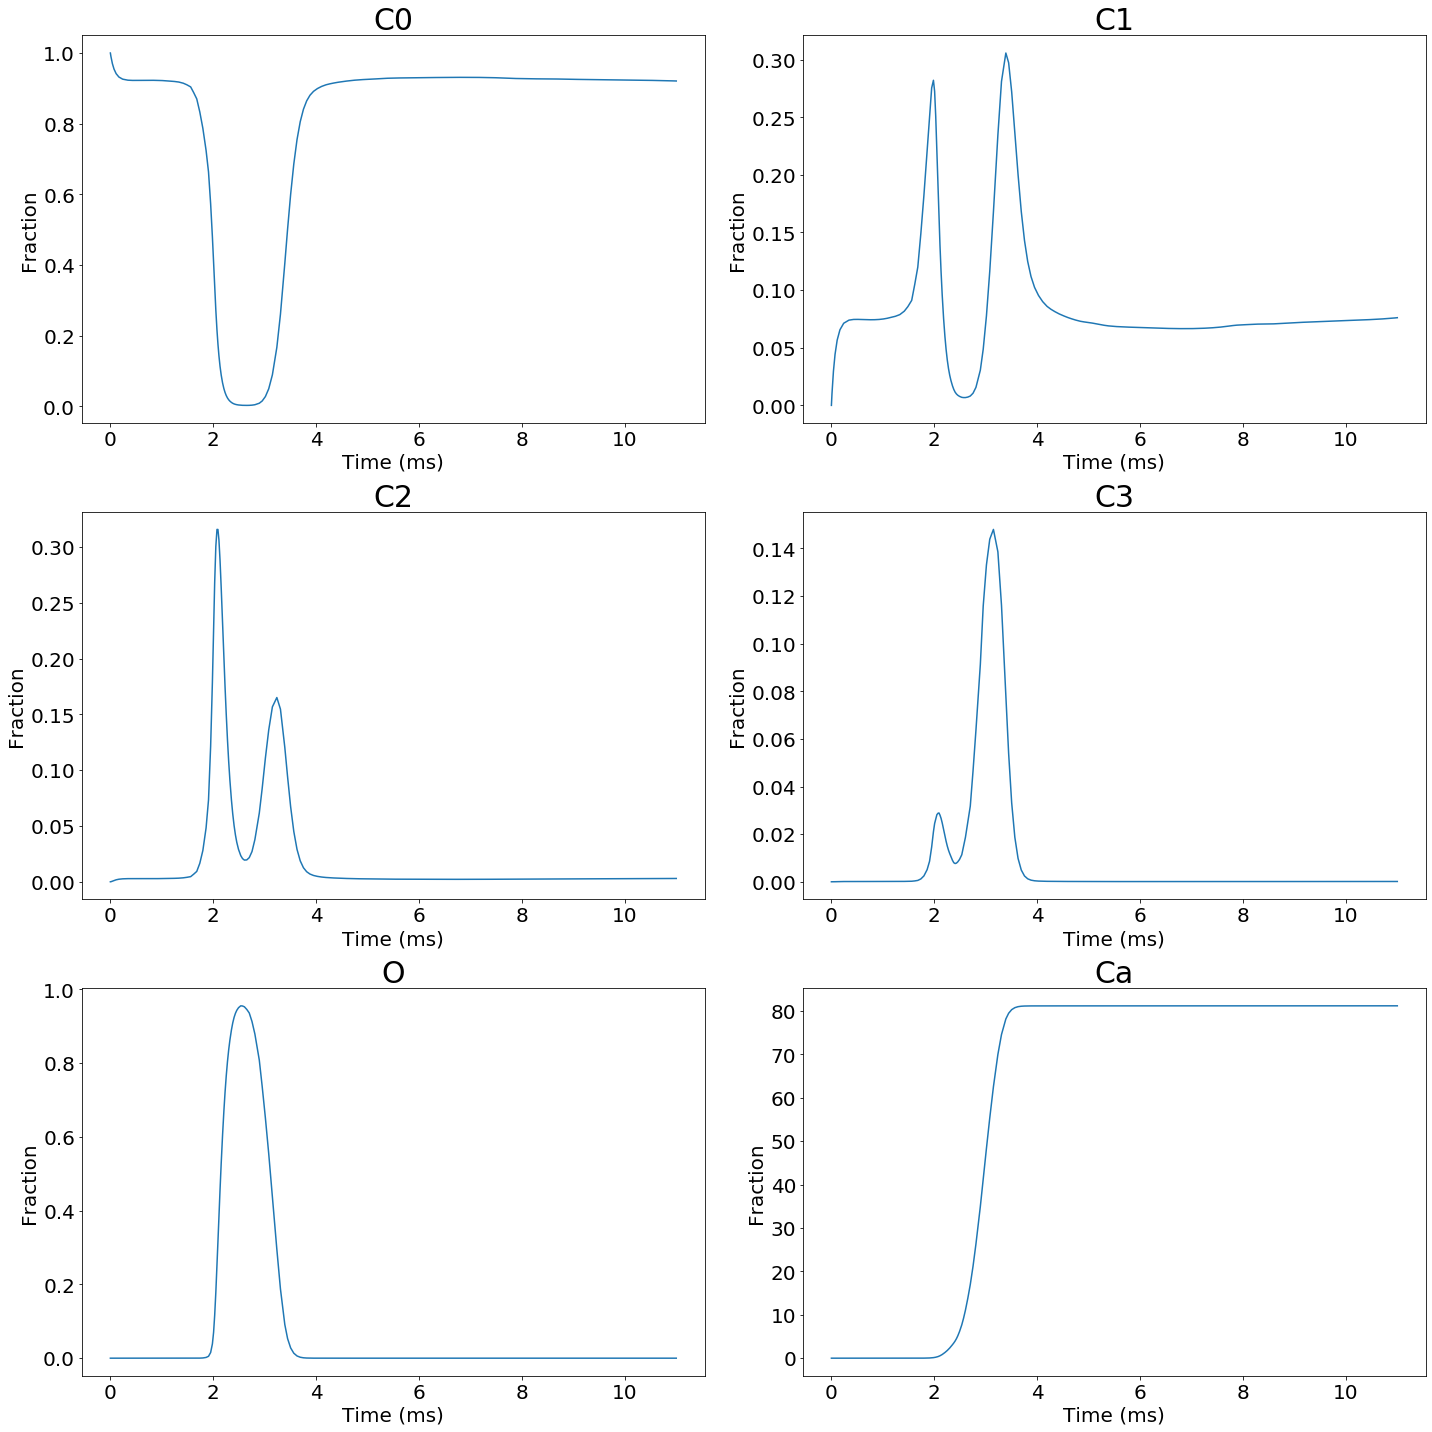

In [10]:
titles = ['C0', 'C1', 'C2', 'C3', 'O', 'Ca']
fig, ax = plt.subplots(3, 2, figsize=(20,20))

for a, i in zip(ax.flatten(), range(sol.y.shape[0])):
    a.plot(sol.t, sol.y[i,:])
    a.set_title(titles[i], size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Fraction', size=20)
    a.tick_params(labelsize=20)
    
plt.tight_layout()
plt.show()

### Full figures

/Users/margotwagner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


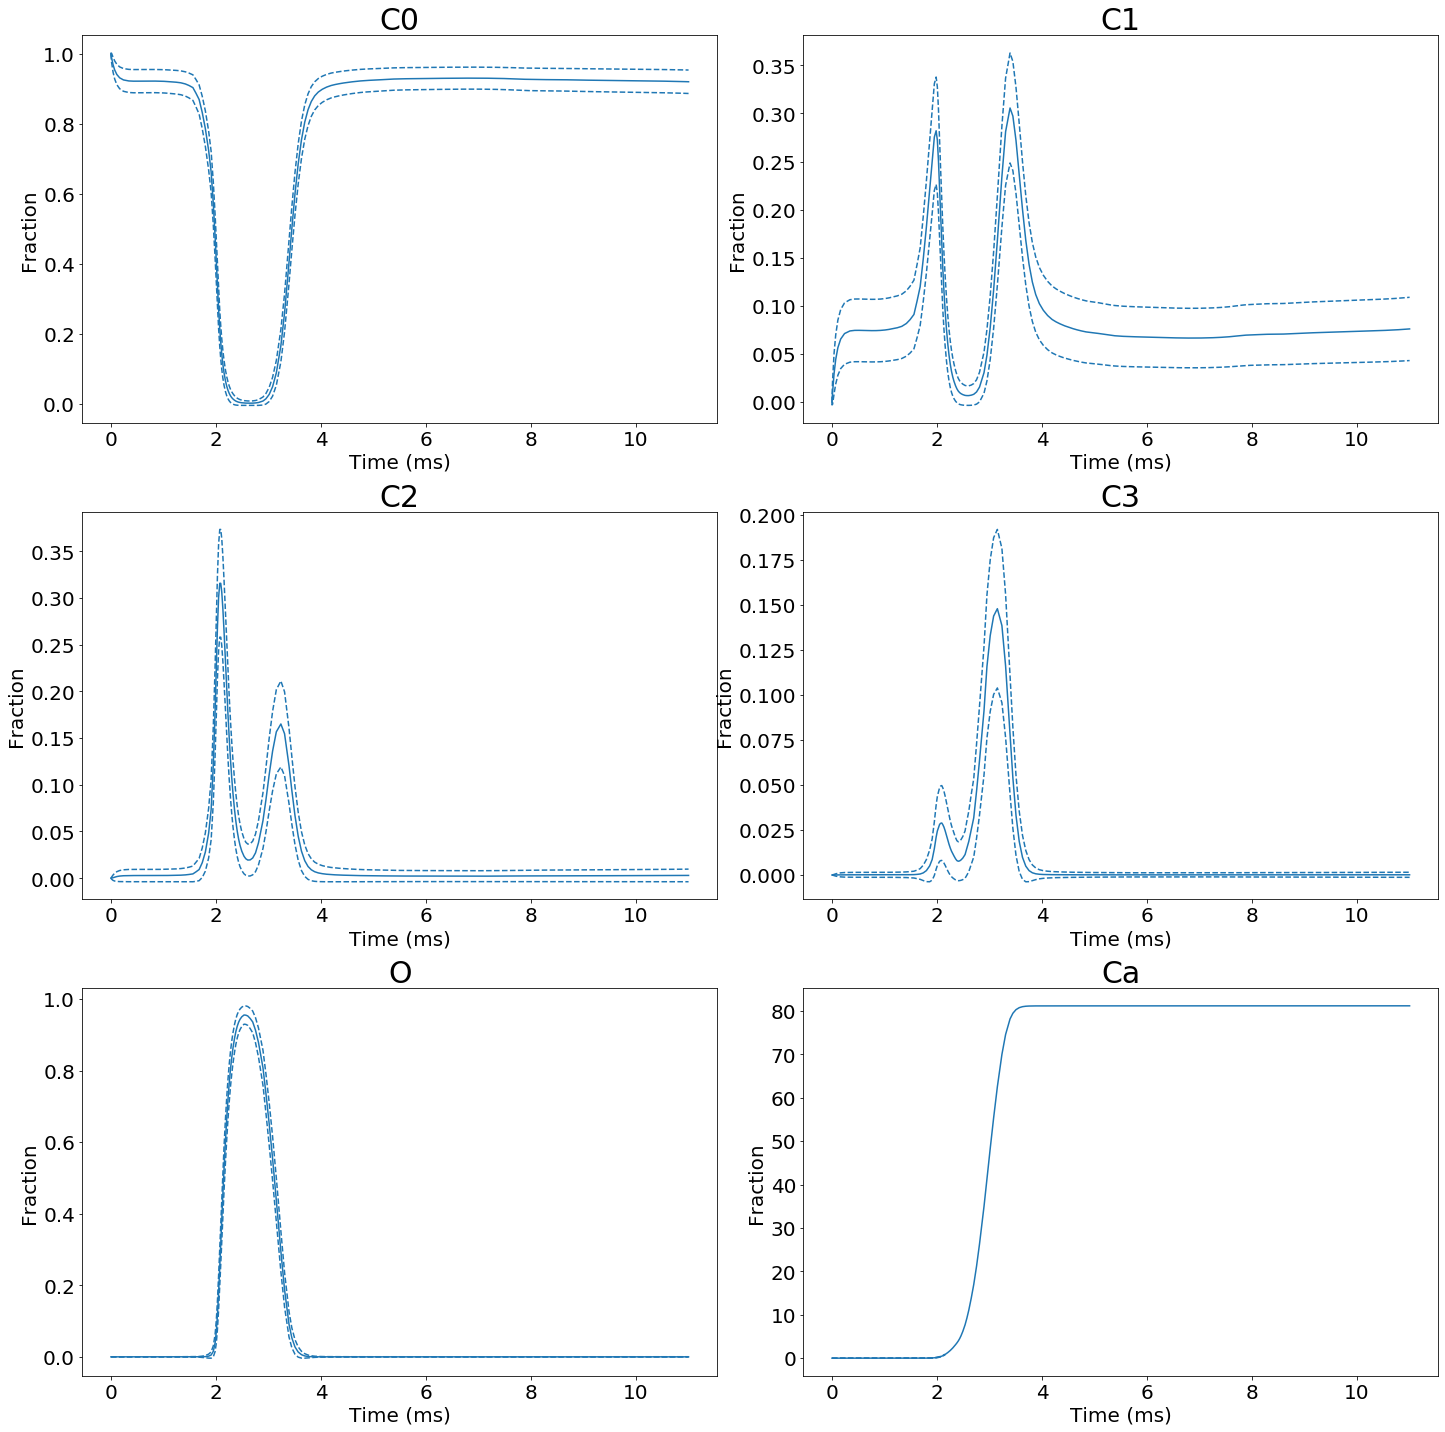

In [36]:
titles = ['C0', 'C1', 'C2', 'C3', 'O', 'Ca']
fig, ax = plt.subplots(3, 2, figsize=(20,20))

for a, i in zip(ax.flatten(), range(sol.y.shape[0])):
    sd = np.sqrt(np.multiply(sol.y[i,:], (1 - sol.y[i,:]))/65)
    a.plot(sol.t, np.add(sol.y[i,:], sd), 'C0--')
    a.plot(sol.t, np.subtract(sol.y[i,:], sd), 'C0--')
    a.plot(sol.t, sol.y[i,:])
    a.set_title(titles[i], size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Fraction', size=20)
    a.tick_params(labelsize=20)
    
plt.tight_layout()
plt.show()

# Markov Simulation

Now that we have all the transition rates defined, we can simulate the Markov process!

The system is initially set to state 0 (C0). For each state throughout the simulation, the state is determined using solely the previous state. Therefore, to find the next state, a probability transition row (p_trans) is obtained for the current state X_t. X_t+1 is determined by taking an inverse transform sample from a multinomial distribution with a probability vector equal to the probability transition row. 

<img src="./figs/vdcc_kinetics.png" width="400">

## Efficient sampling

Using multinomial sampling where the number of experiments is the number of channels in each state and the transition to other states (or no transition) represent the possible outcomes, each with their own probability defined as the transition rate times $\Delta$t.

Similar, calcium influx can be included as a sampling from a binomial distribution. For every open calcium channel (channel in state 4), the vdcc can either allow for the influx of a calcium ion at time t or not. Therefore, you can sampling from a binomial distribution where $n$ is the number of open vdccs; p is the probability of calcium influx, which is just the rate constant $k_{ca}(V)$ times $\Delta$t; and q is just 1 - p. 

## Markov sampling function

In [13]:
# Simulate Markov process for stochastically opening and closing channels

def markov_vdcc_n(n_channels,trange,dt):
    '''
    Simulates a Markov process for the stochastic opening and closing of channels using
    multinomial sampling.
    
    @param n_channels (int) - number of channels to model
    @param trange (int/float array) - array over which the simulation takes place
    @param dt (int/float) - time step
    
    @return n_per_state (int array) - number of channels in each state at each time point (shape: [trange, n_states])
    @return ca (int array) - number of calcium that enters at each time point (shape: [trange])
    @return ca_sum (int array) - total sum of calcium that has entered at that time (shape: [trange])
    '''
    n_states = 5
    n_per_state = np.zeros((len(trange), n_states), dtype=int)
    ca = np.zeros(len(trange), dtype=int)
    ca_sum = np.zeros(len(trange), dtype=int)
    
    # All channels start in C0
    n_per_state[0,0] = n_channels
    
    for t_index in range(len(trange)-1):
        p_trans_0 = [1 - alpha_1(trange[t_index])*dt, alpha_1(trange[t_index])*dt, 0, 0, 0]
        samp0 = np.random.multinomial(n_per_state[t_index,0], p_trans_0)
        
        
        p_trans_1 = [beta_1(trange[t_index])*dt, 1 - (beta_1(trange[t_index])*dt + alpha_2(trange[t_index])*dt), 
                           alpha_2(trange[t_index])*dt, 0, 0]
        samp1 = np.random.multinomial(n_per_state[t_index,1], p_trans_1)
        
        
        p_trans_2 = [0, beta_2(trange[t_index])*dt, 1 - (beta_2(trange[t_index])*dt + alpha_3(trange[t_index])*dt), 
                           alpha_3(trange[t_index])*dt, 0]
        samp2 = np.random.multinomial(n_per_state[t_index,2], p_trans_2)
        
        
        p_trans_3 = [0, 0, beta_3(trange[t_index])*dt, 1 - (beta_3(trange[t_index])*dt + alpha_4(trange[t_index])*dt), 
                           alpha_4(trange[t_index])*dt]
        samp3 = np.random.multinomial(n_per_state[t_index,3], p_trans_3)
        
        
        p_trans_4 = [0, 0, 0, beta_4(trange[t_index])*dt, 1 - beta_4(trange[t_index])*dt]
        samp4 = np.random.multinomial(n_per_state[t_index,4], p_trans_4)
        
        ca[t_index+1] = np.random.binomial(n_per_state[t_index,4], k_ca(trange[t_index])*dt)
        ca_sum[t_index+1] = ca[t_index+1] + ca_sum[t_index]
        
        n_per_state[t_index+1,:] = samp0 + samp1 + samp2 + samp3 + samp4
        
    return n_per_state, ca, ca_sum
        

## 65 Channels (run once)

In [15]:
dt = 1e-3
trange = np.arange(0, 11, 1e-3)
n_per_state, ca, ca_sum = markov_vdcc_n(65, trange, dt)

In [19]:
import time
start = time.time()
dt = 1e-3
trange = np.arange(0, 11, 1e-3)
n_per_state, ca, ca_sum = markov_vdcc_n(65, trange, dt)
end = time.time()

print(end-start)

6.055556297302246


In [40]:
from timeit import timeit
dt = 1e-3
trange = np.arange(0, 11, 1e-3)

%timeit -n 1 -r 10 markov_vdcc_n(65, trange, dt)

6.45 s ± 140 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [39]:
%timeit -n 1 -r 10 x=10

165 ns ± 93.6 ns per loop (mean ± std. dev. of 10 runs, 1 loop each)


### Open channels

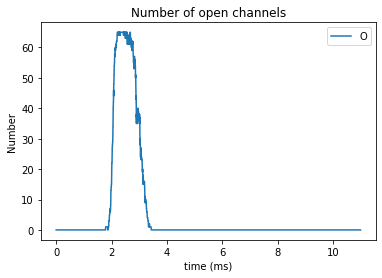

In [16]:
plt.plot(trange,n_per_state[:,4], label='O')
plt.title("Number of open channels")
plt.xlabel("time (ms)")
plt.ylabel("Number")
plt.legend()
plt.show()

### Channels in each state

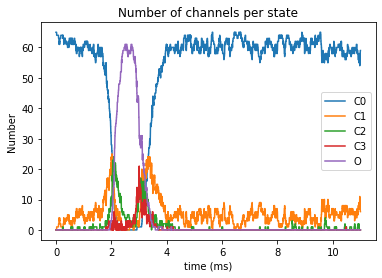

In [15]:
plt.plot(trange,n_per_state[:,0], label='C0')
plt.plot(trange,n_per_state[:,1], label='C1')
plt.plot(trange,n_per_state[:,2], label='C2')
plt.plot(trange,n_per_state[:,3], label='C3')
plt.plot(trange,n_per_state[:,4], label='O')
plt.title("Number of channels per state")
plt.xlabel("time (ms)")
plt.ylabel("Number")
plt.legend()
plt.show()

### Calcium

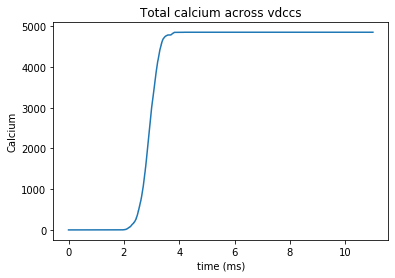

In [16]:
plt.plot(trange, ca_sum)
plt.xlabel("time (ms)")
plt.ylabel("Calcium")
plt.title("Total calcium across vdccs")
plt.show()

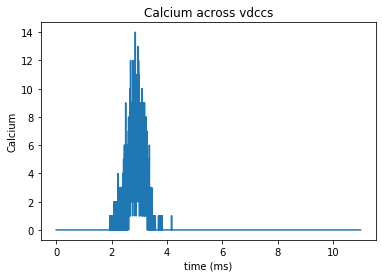

In [17]:
plt.plot(trange, ca)
plt.xlabel("time (ms)")
plt.ylabel("Calcium")
plt.title("Calcium across vdccs")
plt.show()

### MCell comparison

In [19]:
import glob
mcell_dir = "/Users/margotwagner/projects/mcell/simple_geom/model_1_files/mcell/output_data/react_data/seed_00001/"
mcell_results = {}

for fname in glob.glob(os.path.join(mcell_dir, "vdcc_pre_*")):
    data = pd.read_csv(fname, delim_whitespace=True, header=None)
    mcell_results[fname.split('/')[-1].split('.')[0]] = data.to_numpy()

In [20]:
# Plot all the waveforms
fig, ax = plt.subplots(int(len(mcell_results)/2), 2, figsize = (20,20))

for a, (key, value) in zip(ax.flatten(), sorted(mcell_results.items())):
    a.plot(value[:,0]*1000, value[:,1], label="MCell")
    a.set_title(key, size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)
    a.legend(fontsize=18)
    a.tick_params(labelsize=20)
    
for a, i in zip(ax.flatten(), range(4)):
    a.plot(trange,n_per_state[:,i], label="Markov")
    a.legend(fontsize=18)
    
ax[2,0].plot(trange, ca_sum, label="Markov")
ax[2,0].legend(fontsize=18)
ax[2,1].plot(trange,n_per_state[:,4], label="Markov")
ax[2,1].legend(fontsize=18)

plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 0

<Figure size 1440x1440 with 0 Axes>

### 1 vs 100 vs 1000 Channels

In [20]:
n_per_state_1 = markov_vdcc_n(1, trange, dt)
n_per_state_100 = markov_vdcc_n(100, trange, dt)
n_per_state_1k = markov_vdcc_n(1000, trange, dt)

In [21]:
plt.plot(trange,n_per_state_1[:,4], label='O')
plt.plot(trange,n_per_state_100[:,4]/100, label='O')
plt.plot(trange,n_per_state_10k[:,4]/1000, label='O')
plt.title("Number of channels per state")
plt.legend()
plt.show()

TypeError: tuple indices must be integers or slices, not tuple

# Run Markov multiple times
Error is a factor of the square root of the number of measurements.


### Time calculation

In [15]:
def time(seconds): 
    '''
    Python Program to Convert seconds into hours, minutes and seconds 
    
    @param seconds - to convert
    '''
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds) 

## Running

First, we define our constants and time range for the simulation.

In [17]:
# Constants
N_RUNS = 1000
N_VDCC_STATES = 5
N_CHANS = 65

# Time array
dt = 1e-3
trange = np.arange(0, 10+dt, dt)

# Initialize array sizes
ca = np.empty([len(trange), N_RUNS])
ca_sum = np.empty([len(trange), N_RUNS])
vdcc_states = np.empty([len(trange), N_VDCC_STATES, N_RUNS])

# Expected time for simulation to run
print("This simulation should take approximately", time(7*N_RUNS), "to run.")

This simulation should take approximately 1:56:40 to run.


Then we can run as many simulations as we want (~7 sec per simulation).  

In [18]:
# Run simulation
for i in range(N_RUNS):
    vdcc_states[:, :, i], ca[:, i], ca_sum[:, i] = markov_vdcc_n(N_CHANS, trange, dt)

In order to use seaborn, we first have to organize the data using a pandas dataframe.

In [19]:
# trial number for each time point
trial = np.empty(N_RUNS*len(trange))

for run in range(N_RUNS):
    for tp in range(len(trange)):
        trial[len(trange)*run + tp] = run + 1
        
# repeat timepoints for each trial
timepoints = np.tile(trange, N_RUNS)

In [20]:
results = pd.DataFrame(trial, columns=['trial'])
results['timepoints'] = timepoints
for i in range(4):
    results['vdcc_c{:d}'.format(i)] = vdcc_states[:, i, :].flatten('F')
results['vdcc_o'] = vdcc_states[:, 4, :].flatten('F')
results['ca_sum'] = ca_sum.flatten('F')
results['ca'] = ca.flatten('F')

In [21]:
print(results.shape)
results.head()

(10001000, 9)


,trial,timepoints,vdcc_c0,vdcc_c1,vdcc_c2,vdcc_c3,vdcc_o,ca_sum,ca
0,1.0,0.000,65.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.001,65.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.002,65.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.003,64.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.004,64.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
from math import ceil

MAX_STORE = 1000000

# Save data
for i in range(int(ceil(results.shape[0]/MAX_STORE))):
    # Save to csv
    results.iloc[i*MAX_STORE:(i+1)*MAX_STORE].to_csv('markov_1000_runs_{:d}.csv'.format(i), index=False)

## Plotting

We can then use seaborn relplot(), which is a figure-level function for visualizing statistical relationships, including the option to use line plots. This allows us to visualize the mean and the standard deviation.

In [23]:
import seaborn as sns
sns.set(style="darkgrid")

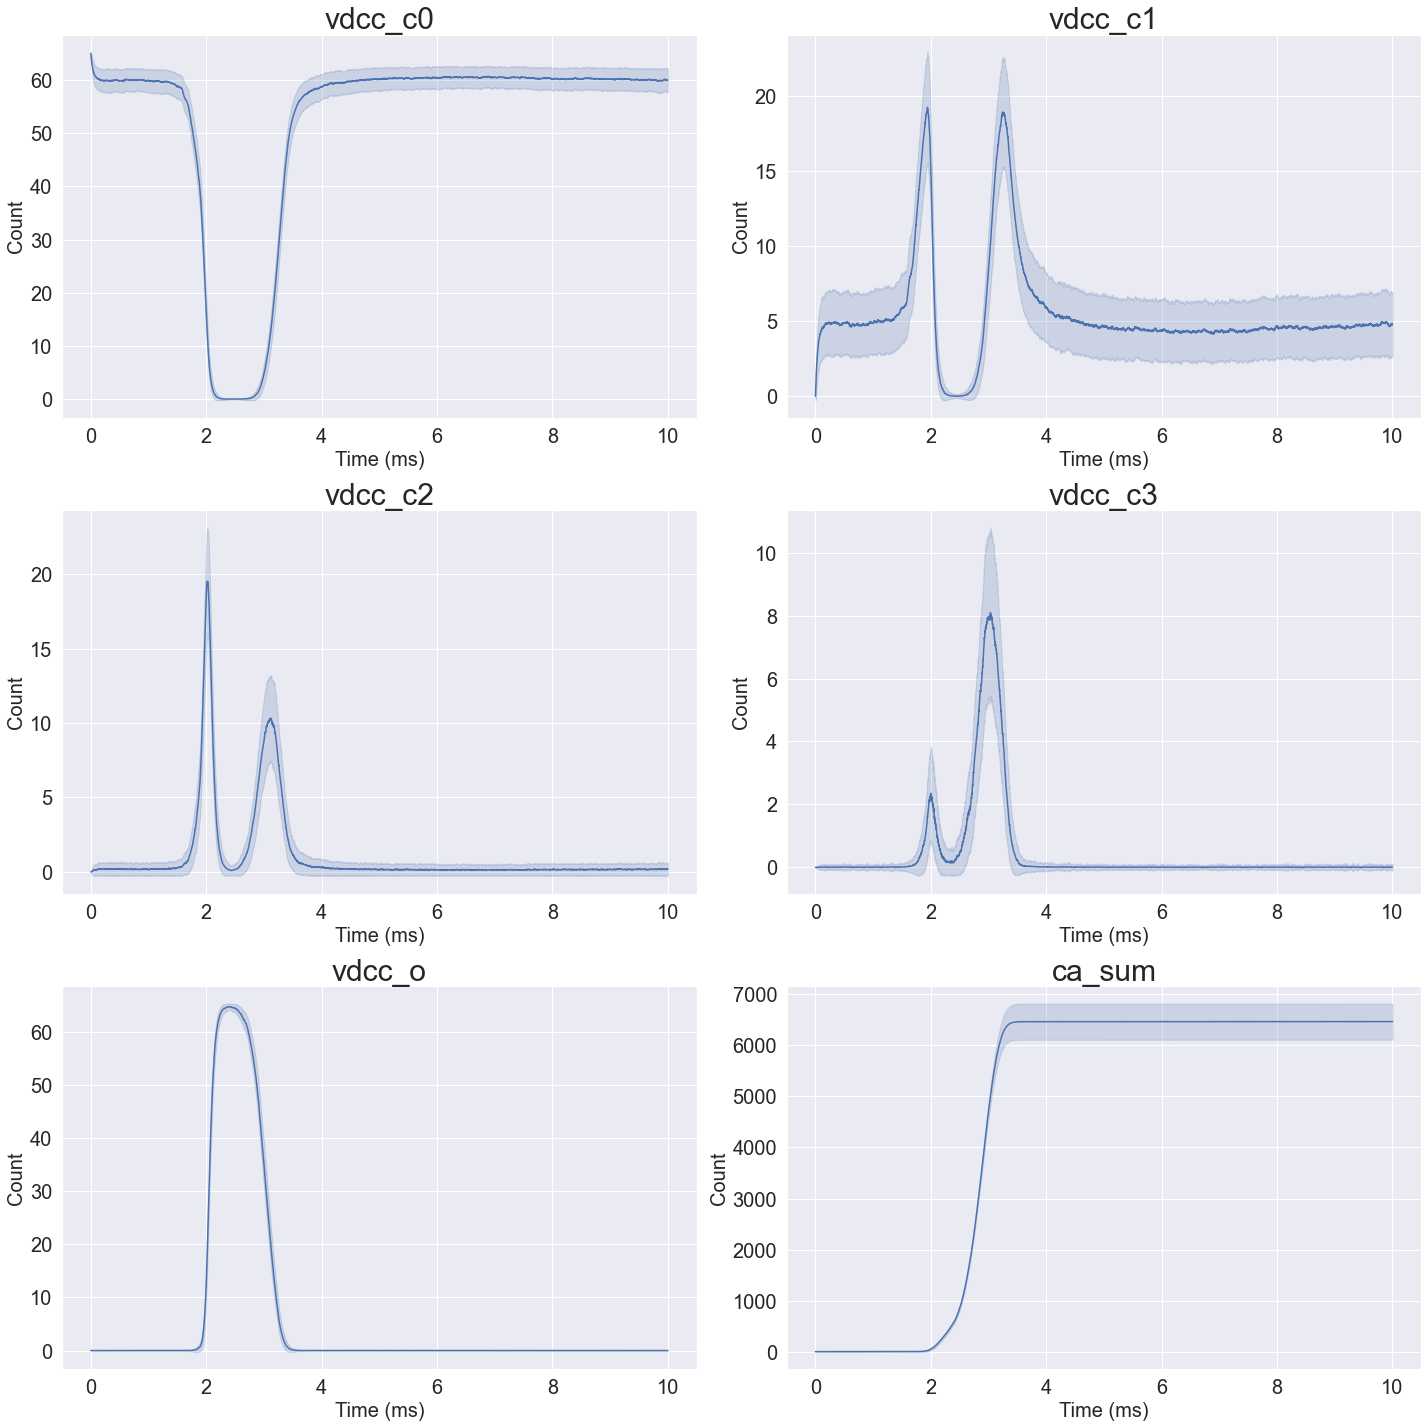

In [26]:
fig, ax = plt.subplots(3, 2, figsize = (20,20))

for a, col in zip(ax.flatten(), results.columns[2:]):
    #sns.relplot(x="timepoints", y=col, kind="line", ci="sd", data=results, ax=a)
    sns.lineplot(x="timepoints", y=col, ci="sd", data=results, ax=a)
    a.set_title(col, size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)
    a.tick_params(labelsize=20)
 

for i in range(2,8): 
    plt.close(i)
    
plt.tight_layout()
plt.show()


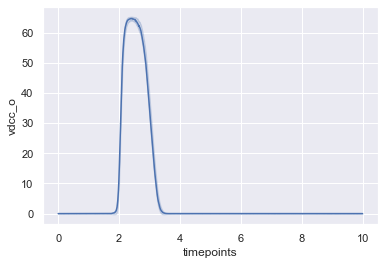

In [29]:
sns.lineplot(x="timepoints", y="vdcc_o", ci="sd", data=results)
plt.show()

# MCell channel comparison

### Single MCell run

In [68]:
import glob
mcell_dir = "/Users/margotwagner/projects/mcell/simple_geom/model_1_files/mcell/output_data/react_data/seed_00001/"
mcell_results = {}

for fname in glob.glob(os.path.join(mcell_dir, "vdcc_pre_*")):
    data = pd.read_csv(fname, delim_whitespace=True, header=None)
    mcell_results[fname.split('/')[-1].split('.')[0]] = data.to_numpy()

mcell_results['z_ca_sum'] = mcell_results.pop('vdcc_pre_ca_flux')

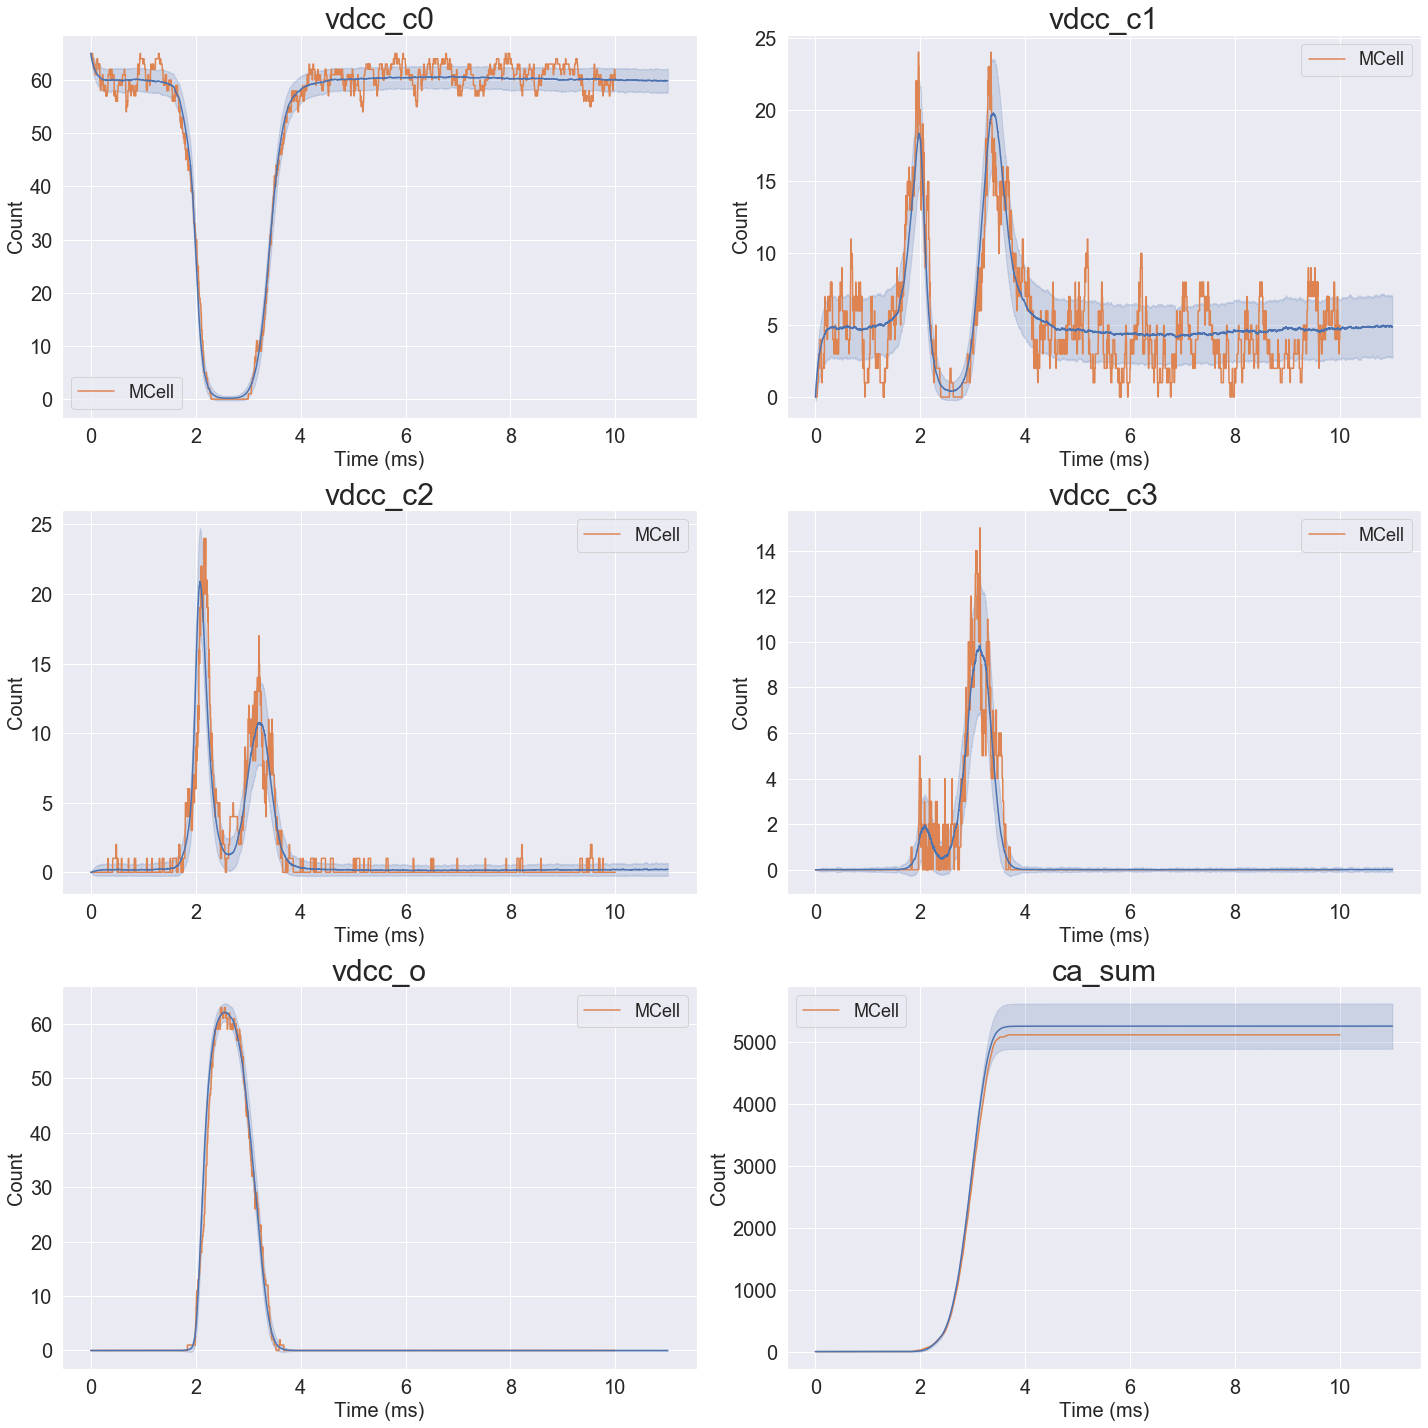

In [69]:
# Plot all the waveforms
fig, ax = plt.subplots(int(len(mcell_results)/2), 2, figsize = (20,20))

for a, (key, value) in zip(ax.flatten(), sorted(mcell_results.items())):
    a.plot(value[:,0]*1000, value[:,1], 'C1', label="MCell")
    a.legend(fontsize=18)
    
for a, col in zip(ax.flatten(), results.columns[2:]):
    sns.relplot(x="timepoints", y=col, kind="line", ci="sd", data=results, ax=a)
    a.set_title(col, size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)
    a.tick_params(labelsize=20)
    
for i in range(2,8): 
    plt.close(i)
    
plt.tight_layout()
plt.show()

### Multiple mcell runs

In [1]:
import glob
# Constants
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_files/mcell/output_data/react_data/"
SEEDS = 10
DATA_DIM = 2
T_START = 0
ITERATIONS = 10000
T_STEP = 1e-6
T_STOP = ITERATIONS * T_STEP
T_RANGE = np.arange(T_START, T_STOP + T_STEP/2, T_STEP)

# Molecule data file names (ie ca.World.dat)
mol_files = []
mol_names = []
for file_path in glob.glob(os.path.join(MCELL_DIR, "seed_00001/vdcc_pre_o.World.dat")):
    print(file_path)
    mol_file = file_path.split('/')[-1]
    mol_files.append(mol_file)
    mol_names.append(mol_file.split('.')[0])
    
# Initialize data arrays
# Data is list of np arrays n_mol in length
mcell_data = []
for i in range(len(mol_files)):
    mcell_data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))   # time x features (2 time, val) x seeds

# Add data to all arrays
for seed in range(SEEDS):
    for i in range(len(mol_files)):
        fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed+1), mol_files[i])
        mcell_data[i][:,:,seed] = pd.read_csv(fname, delim_whitespace=True, header=None)

NameError: name 'os' is not defined

In [3]:
import glob
# Constants
MCELL_DIR = "/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_nodendrite_files/mcell/output_data/react_data/"
SEEDS = 1
DATA_DIM = 2
T_START = 0
ITERATIONS = 10000
T_STEP = 1e-6
T_STOP = ITERATIONS * T_STEP
T_RANGE = np.arange(T_START, T_STOP + T_STEP/2, T_STEP)

# Molecule data file names (ie ca.World.dat)
mol_files = []
mol_names = []
for file_path in glob.glob(os.path.join(MCELL_DIR, "seed_00001/vdcc_pre_o.World.dat")):
    print(file_path)
    mol_file = file_path.split('/')[-1]
    mol_files.append(mol_file)
    mol_names.append(mol_file.split('.')[0])
    
# Initialize data arrays
# Data is list of np arrays n_mol in length
mcell_data = []
for i in range(len(mol_files)):
    mcell_data.append(np.empty([len(T_RANGE), DATA_DIM, SEEDS]))   # time x features (2 time, val) x seeds

# Add data to all arrays
for seed in range(SEEDS):
    for i in range(len(mol_files)):
        fname = os.path.join(MCELL_DIR, "seed_{:05d}".format(seed+1), mol_files[i])
        mcell_data[i][:,:,seed] = pd.read_csv(fname, delim_whitespace=True, header=None)

/Users/margotwagner/projects/mcell/simple_geom/model_1/model_1_vdcceqtns_tchange_nodendrite_files/mcell/output_data/react_data/seed_00001/vdcc_pre_o.World.dat


In [4]:
mcell_data[0].shape

(10001, 2, 1)

In [5]:
'''Normalize'''
vdcc_o_idx = 0

mcell_data_norm = np.copy(mcell_data)

for seed in range(SEEDS):
    mcell_data_norm[vdcc_o_idx][:,1,seed] = mcell_data_norm[vdcc_o_idx][:,1,seed] / (65)

In [6]:
mcell_data_norm

array([[[[0.000e+00],
         [0.000e+00]],

        [[1.000e-06],
         [0.000e+00]],

        [[2.000e-06],
         [0.000e+00]],

        ...,

        [[9.998e-03],
         [0.000e+00]],

        [[9.999e-03],
         [0.000e+00]],

        [[1.000e-02],
         [0.000e+00]]]])

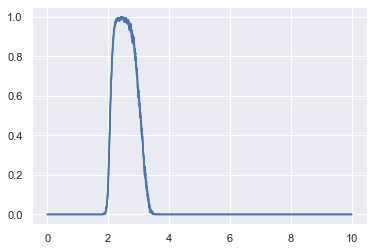

In [74]:
from scipy import stats
# Mean
mean = np.mean(mcell_data_norm[0], axis=2)
plt.plot(mean[:,0]*1000, mean[:,1], color='g', label='MCell', )

# SEM
sem = stats.sem(mcell_data_norm[0], axis=2)
plt.plot(mean[:,0]*1000, mean[:,1] + sem[:,1], 'C0')
plt.plot(mean[:,0]*1000, mean[:,1] - sem[:,1], 'C0')

# Plot labels
#a.set_title(mol_names[mol], size=20)
#a.set_xlabel('Time (ms)', size=20)
#a.set_ylabel('Fraction', size=20)
#a.legend()

## Comparison with ODE Solution

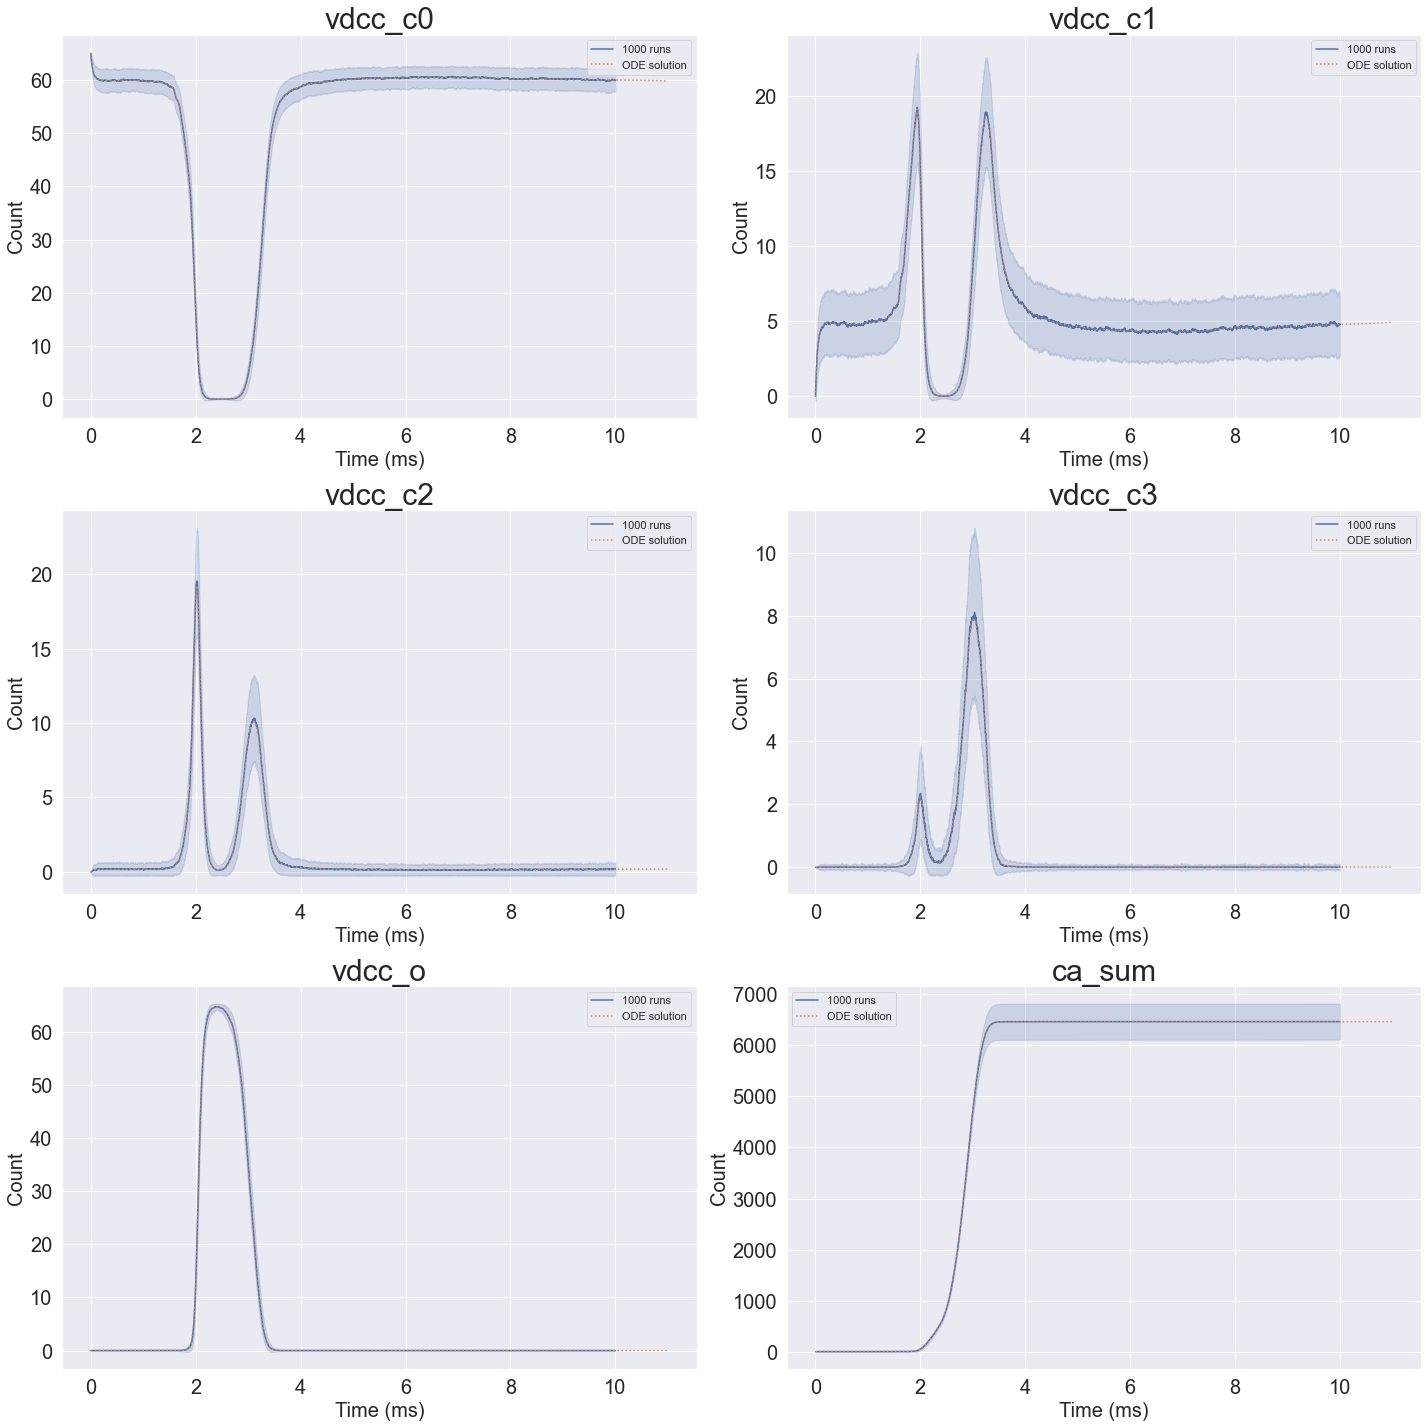

In [27]:
fig, ax = plt.subplots(3, 2, figsize = (20,20))

i = 0
for a, col in zip(ax.flatten(), results.columns[2:]):
    #sns.relplot(x="timepoints", y=col, kind="line", ci="sd", data=results, ax=a)
    sns.lineplot(x="timepoints", y=col, ci="sd", data=results, ax=a)
    a.plot(sol.t, 65*sol.y[i,:], color='C1', linestyle = ':')
    a.set_title(col, size=30)
    a.set_xlabel('Time (ms)', size=20)
    a.set_ylabel('Count', size=20)
    a.tick_params(labelsize=20)
    a.legend(['1000 runs', 'ODE solution'])
    i += 1
 

for i in range(2,8): 
    plt.close(i)
    
plt.tight_layout()
plt.show()

## Distributions per timepoint

In [78]:
results

,trial,timepoints,vdcc_c0,vdcc_c1,vdcc_c2,vdcc_c3,vdcc_o,ca_sum,ca
0,1.0,0.000,65.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.001,65.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.002,65.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.003,65.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.004,65.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
11000995,1000.0,10.996,63.0,2.0,0.0,0.0,0.0,4506.0,0.0
11000996,1000.0,10.997,63.0,2.0,0.0,0.0,0.0,4506.0,0.0
11000997,1000.0,10.998,63.0,2.0,0.0,0.0,0.0,4506.0,0.0
11000998,1000.0,10.999,63.0,2.0,0.0,0.0,0.0,4506.0,0.0


In [79]:
from scipy import stats
sns.set(color_codes=True)

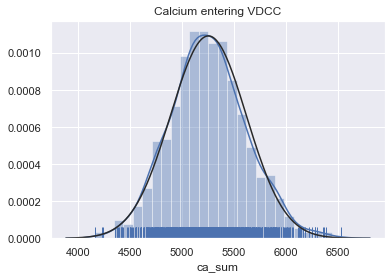

In [80]:
sns.distplot(results.loc[results['timepoints'] == 11]['ca_sum'], rug=True, fit=stats.norm) # remove gaussian? (thin dotted)
plt.title("Calcium entering VDCC")
plt.show()

Unsure why probabilities are so small?

In [81]:
vdcc_o_max_t = round(results.loc[results['vdcc_o'] == results['vdcc_o'].max()]['timepoints'].mean(), 3)
vdcc_o_max_t

2.568

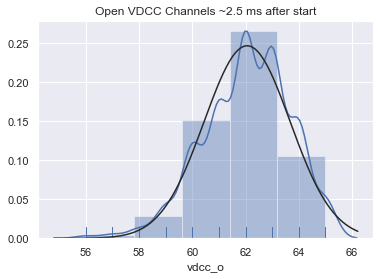

In [82]:
sns.distplot(results.loc[results['timepoints'] == 2.582]['vdcc_o'], rug=True, fit=stats.norm, bins=5)
plt.title("Open VDCC Channels ~2.5 ms after start")
plt.show()

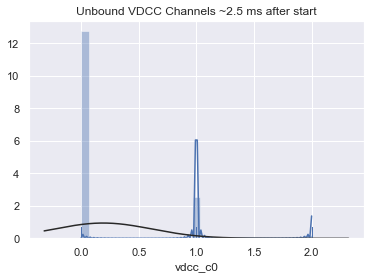

In [83]:
sns.distplot(results.loc[results['timepoints'] == 2.582]['vdcc_c0'], rug=True, fit=stats.norm)
plt.title("Unbound VDCC Channels ~2.5 ms after start")
plt.show()

# Summary
Comparison between Markov runs, MCell runs, and ODE solution.

In [37]:
results['vdcc_o_norm'] = results['vdcc_o']/N_CHANS

In [7]:
results.head()

NameError: name 'results' is not defined

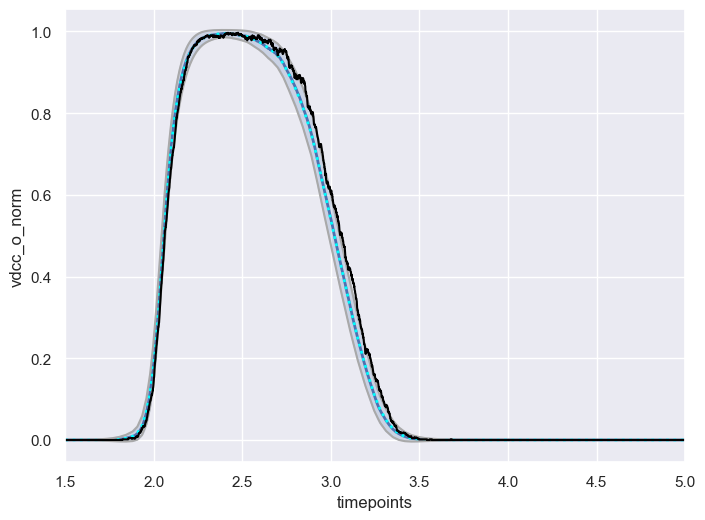

In [100]:
plt.figure(figsize=(8,6), dpi=100)
# MARKOV
sns.lineplot(x="timepoints", y="vdcc_o_norm", ci="sd", data=results, linewidth=2)

# ODE
plt.plot(sol.t, sol.y[4,:], color='cyan', linestyle = ':', linewidth=2)
sd = np.sqrt(np.multiply(sol.y[4,:], (1 - sol.y[4,:]))/N_CHANS)
plt.plot(sol.t, np.add(sol.y[4,:], sd), color='darkgrey')
plt.plot(sol.t, np.subtract(sol.y[4,:], sd), color='darkgrey')

# MCELL
# Mean
mean = np.mean(mcell_data_norm[0], axis=2)
plt.plot(mean[:,0]*1000, mean[:,1], color='black', label='MCell', )

# SEM
#sem = stats.sem(mcell_data_norm[0], axis=2)
#plt.plot(mean[:,0]*1000, mean[:,1] + sem[:,1], 'C0')
#plt.plot(mean[:,0]*1000, mean[:,1] - sem[:,1], 'C0')



plt.xlim(1.5,5)
plt.show()

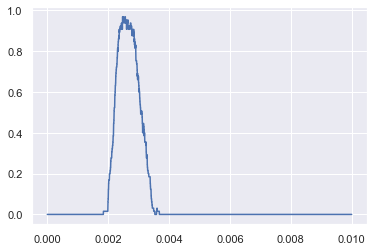

In [97]:
plt.plot(test[0], test[1]/65)

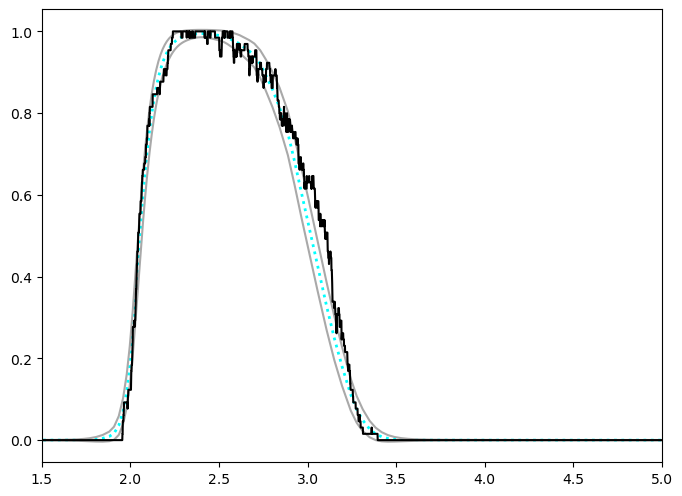

In [21]:
plt.figure(figsize=(8,6), dpi=100)
N_CHANS=65
# MARKOV
#sns.lineplot(x="timepoints", y="vdcc_o_norm", ci="sd", data=results, linewidth=2)

# ODE
plt.plot(sol.t, sol.y[4,:], color='cyan', linestyle = ':', linewidth=2)
sd = np.sqrt(np.multiply(sol.y[4,:], (1 - sol.y[4,:]))/N_CHANS)
plt.plot(sol.t, np.add(sol.y[4,:], sd), color='darkgrey')
plt.plot(sol.t, np.subtract(sol.y[4,:], sd), color='darkgrey')

# MCELL
# Mean
mean = np.mean(mcell_data_norm[0], axis=2)
plt.plot(mean[:,0]*1000, mean[:,1], color='black', label='MCell', )

# SEM
#sem = stats.sem(mcell_data_norm[0], axis=2)
#plt.plot(mean[:,0]*1000, mean[:,1] + sem[:,1], 'C0')
#plt.plot(mean[:,0]*1000, mean[:,1] - sem[:,1], 'C0')



plt.xlim(1.5,5)
plt.show()